In [17]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##Load training data
trnImages = np.load('trnImage.npy')
tstImages = np.load('tstImage.npy')

trnLabel = np.load('trnLabel.npy')
tstLabel = np.load('tstLabel.npy')

#Load extracted data (hog of training images)
extTrnFeat = np.load('extTrnFeat.npy')
extTstFeat = np.load('extTstFeat.npy')

# Extract Features

Here I extract HOG Features

In [19]:
def computeHogFeatures(image):    
    hog_feature = skimage.feature.hog(image, visualize=False, block_norm='L2-Hys')
    return hog_feature

#Extract Traing Data
extractedTrainFeatures = np.zeros((10000,324))
for i in range(10000):
    extractedTrainFeatures[i] = computeHogFeatures(trnImages[:,:,:,i])

#Extract Testing Data
extractedTestFeatures = np.zeros((1000,324))
for i in range(1000):
    extractedTestFeatures[i] = computeHogFeatures(tstImages[:,:,:,i])
    
#Save externally
np.save('extTrnFeat.npy',extractedTrainFeatures)
np.save('extTstFeat.npy',extractedTestFeatures)

In [18]:
x_train = extTrnFeat
y_train = trnLabel  -1 # -1 so labels are 0-9 not 1-10

x_test = extTstFeat 
y_test = tstLabel -1 # -1 so labels are 0-9 not 1-10


# Neural Network on control dataset

Here a neural network is trained on the unreduced HOG features 

Epoch 1/50
10000/10000 [==============================] - 42s 4ms/step - loss: 1.8541 - acc: 0.3591
Epoch 2/50
10000/10000 [==============================] - 7s 725us/step - loss: 1.5559 - acc: 0.4684 0s - loss: 1.55
Epoch 3/50
10000/10000 [==============================] - 8s 767us/step - loss: 1.4778 - acc: 0.4902 0s - loss: 1.4782 -
Epoch 4/50
10000/10000 [==============================] - 8s 794us/step - loss: 1.4251 - acc: 0.5066 1s - loss: 1.426
Epoch 5/50
10000/10000 [==============================] - 8s 751us/step - loss: 1.3892 - acc: 0.5213
Epoch 6/50
10000/10000 [==============================] - 8s 805us/step - loss: 1.3555 - acc: 0.5268
Epoch 7/50
10000/10000 [==============================] - 9s 853us/step - loss: 1.3245 - acc: 0.5379 0s - loss: 1.3232 - acc
Epoch 8/50
10000/10000 [==============================] - 9s 947us/step - loss: 1.3020 - acc: 0.5457
Epoch 9/50
10000/10000 [==============================] - 8s 819us/step - loss: 1.2741 - acc: 0.5515
Epoch 10/50
100

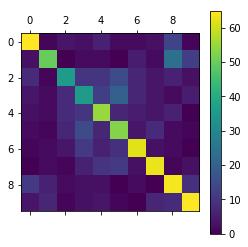

1000/1000 [==============================] - 18s 18ms/step

Models loss is 1.3535373802185058
Models accuracy is 0.549


In [31]:
# Neural Network on full dataset

import tensorflow as tf

#Create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))  

#Define hyperparameters
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train model
model.fit(x_train, y_train, epochs=50)  # train the model
print()

y_pred = model.predict_classes(x_test)
print("Confusion matrix of control dataset")
cm = confusion_matrix(y_test, y_pred, [0,1,2,3,4,5,6,7,8,9])
plt.matshow(cm)
plt.colorbar()
plt.show()

#Evaluate model
val_loss, val_acc = model.evaluate(x_test, y_test) 
print()
print(f"Models loss is {val_loss}")
print(f"Models accuracy is {val_acc}")



# Principle Component Analysis

Here the varience of data is graphed

Text(0, 0.5, 'Variance of Data')

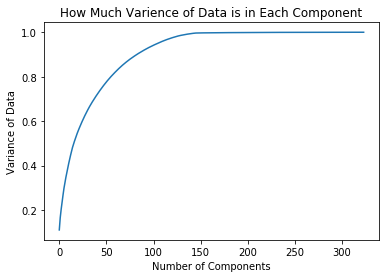

In [16]:
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("How Much Varience of Data is in Each Component")
plt.xlabel("Number of Components")
plt.ylabel("Variance of Data")

# Neural Network on varying amounts of principle components
To determine if there is an optimum number of principle components to use a neural network with the same architecture has been used on an increasing amount of features

In [10]:
#Looping through different numbers of pca components

pcaComponents = np.zeros((150,1))

for i in range(150): 
    
    i = i+1
    print(i)
    pcai = PCA(n_components=i)
    pcai.fit(x_train)    
    pcai_x_train = pcai.transform(x_train)
    pcai_x_test = pcai.transform(x_test)
    
    #Create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))  

    #Define hyperparameters
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    #Train model
    model.fit(pcai_x_train, y_train, epochs=5)  # train the model
    
    val_loss, val_acc = model.evaluate(pcai_x_test, y_test)
    print()
    print(f"Models accuracy with {i} components is: {val_acc}")  
    print()
    pcaComponents[i-1] = val_acc 

np.save('pca_number_of_comps_150.npy',pcaComponents)

1
Epoch 1/5
10000/10000 [==============================] - 8s 784us/step - loss: 2.1143 - acc: 0.1812
Epoch 2/5
10000/10000 [==============================] - 1s 109us/step - loss: 2.0317 - acc: 0.2119
Epoch 3/5
10000/10000 [==============================] - 2s 171us/step - loss: 2.0249 - acc: 0.2162 2s -
Epoch 4/5
10000/10000 [==============================] - 1s 147us/step - loss: 2.0222 - acc: 0.2174
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step

Models accuracy with 1 components is: 0.234

2
Epoch 1/5
10000/10000 [==============================] - 8s 758us/step - loss: 2.1069 - acc: 0.2002
Epoch 2/5
10000/10000 [==============================] - 1s 121us/step - loss: 1.9981 - acc: 0.2437
Epoch 3/5
10000/10000 [==============================] - 1s 117us/step - loss: 1.9696 - acc: 0.2503
Epoch 4/5
10000/10000 [==============================] - 1s 128us/step - loss: 1.9576 - acc: 0.2520
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step

Models acc

10000/10000 [==============================] - ETA: 0s - loss: 1.6187 - acc: 0.4430- ETA: 0s - loss: 1.6503 - a - 1s 133us/step - loss: 1.6191 - acc: 0.4426
Epoch 3/5
10000/10000 [==============================] - 1s 137us/step - loss: 1.5469 - acc: 0.4583
Epoch 4/5
10000/10000 [==============================] - 2s 153us/step - loss: 1.5135 - acc: 0.4665
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step

Models accuracy with 27 components is: 0.455

28
Epoch 1/5
10000/10000 [==============================] - 9s 876us/step - loss: 2.0040 - acc: 0.3403
Epoch 2/5
10000/10000 [==============================] - 2s 154us/step - loss: 1.6164 - acc: 0.4519
Epoch 3/5
10000/10000 [==============================] - 1s 138us/step - loss: 1.5345 - acc: 0.4650 0s - loss: 1.5400 - acc
Epoch 4/5
10000/10000 [==============================] - 1s 132us/step - loss: 1.4997 - acc: 0.4732
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/step

Models accuracy with 28 components

10000/10000 [==============================] - 2s 180us/step - loss: 1.4421 - acc: 0.5010 
Epoch 4/5
10000/10000 [==============================] - 2s 184us/step - loss: 1.4062 - acc: 0.5124
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/step

Models accuracy with 53 components is: 0.507

54
Epoch 1/5
10000/10000 [==============================] - 12s 1ms/step - loss: 1.9784 - acc: 0.3537
Epoch 2/5
10000/10000 [==============================] - 2s 154us/step - loss: 1.5447 - acc: 0.4803
Epoch 3/5
10000/10000 [==============================] - 2s 155us/step - loss: 1.4449 - acc: 0.5004
Epoch 4/5
10000/10000 [==============================] - 2s 155us/step - loss: 1.4077 - acc: 0.5122
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/step

Models accuracy with 54 components is: 0.51

55
Epoch 1/5
10000/10000 [==============================] - 10s 1ms/step - loss: 1.9786 - acc: 0.3611
Epoch 2/5
10000/10000 [==============================] - 2s 155us/step - loss:

1000/1000 [==============================] - 7s 7ms/step

Models accuracy with 79 components is: 0.509

80
Epoch 1/5
10000/10000 [==============================] - 13s 1ms/step - loss: 1.9736 - acc: 0.3603
Epoch 2/5
10000/10000 [==============================] - 2s 225us/step - loss: 1.5206 - acc: 0.4907
Epoch 3/5
10000/10000 [==============================] - 2s 215us/step - loss: 1.4097 - acc: 0.5114
Epoch 4/5
10000/10000 [==============================] - 2s 214us/step - loss: 1.3679 - acc: 0.5258
Epoch 5/5
1000/1000 [==============================] - 6s 6ms/step

Models accuracy with 80 components is: 0.516

81
Epoch 1/5
10000/10000 [==============================] - 19s 2ms/step - loss: 1.9834 - acc: 0.3607
Epoch 2/5
10000/10000 [==============================] - 2s 215us/step - loss: 1.5208 - acc: 0.4910
Epoch 3/5
10000/10000 [==============================] - 2s 218us/step - loss: 1.4081 - acc: 0.5126
Epoch 4/5
10000/10000 [==============================] - 2s 215us/step - loss:

Epoch 1/5
10000/10000 [==============================] - 18s 2ms/step - loss: 1.9723 - acc: 0.3671
Epoch 2/5
10000/10000 [==============================] - 3s 302us/step - loss: 1.5074 - acc: 0.4929
Epoch 3/5
10000/10000 [==============================] - 3s 284us/step - loss: 1.3884 - acc: 0.5242
Epoch 4/5
10000/10000 [==============================] - 3s 314us/step - loss: 1.3415 - acc: 0.5332
Epoch 5/5
1000/1000 [==============================] - 9s 9ms/step

Models accuracy with 106 components is: 0.528

107
Epoch 1/5
10000/10000 [==============================] - 18s 2ms/step - loss: 1.9833 - acc: 0.3654
Epoch 2/5
10000/10000 [==============================] - 3s 298us/step - loss: 1.5107 - acc: 0.5000
Epoch 3/5
10000/10000 [==============================] - 3s 316us/step - loss: 1.3892 - acc: 0.5216
Epoch 4/5
10000/10000 [==============================] - 3s 282us/step - loss: 1.3411 - acc: 0.5357
Epoch 5/5
1000/1000 [==============================] - 7s 7ms/step

Models accuracy

10000/10000 [==============================] - 3s 287us/step - loss: 1.3759 - acc: 0.5246
Epoch 4/5
10000/10000 [==============================] - 3s 289us/step - loss: 1.3237 - acc: 0.5435
Epoch 5/5
1000/1000 [==============================] - 8s 8ms/step

Models accuracy with 132 components is: 0.533

133
Epoch 1/5
10000/10000 [==============================] - 20s 2ms/step - loss: 1.9711 - acc: 0.3728
Epoch 2/5
10000/10000 [==============================] - 3s 285us/step - loss: 1.4968 - acc: 0.5002
Epoch 3/5
10000/10000 [==============================] - 3s 289us/step - loss: 1.3758 - acc: 0.5288
Epoch 4/5
10000/10000 [==============================] - 3s 311us/step - loss: 1.3257 - acc: 0.5418
Epoch 5/5
1000/1000 [==============================] - 7s 7ms/step

Models accuracy with 133 components is: 0.526

134
Epoch 1/5
10000/10000 [==============================] - 19s 2ms/step - loss: 1.9884 - acc: 0.3642
Epoch 2/5
10000/10000 [==============================] - 3s 298us/step - l

# Graphing Results
The accuracy of each neural network is plotted against the number of PCA componenets in the input layer of that network

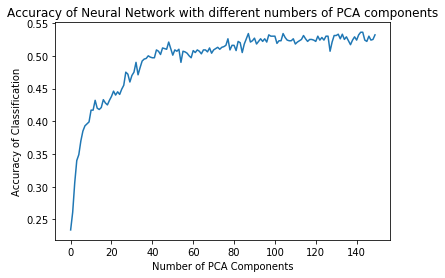

In [12]:

pcaGraph = np.load('pca_number_of_comps_150.npy')
plt.plot(pcaGraph)
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy of Classification')
plt.title('Accuracy of Neural Network with different numbers of PCA components')
plt.show()


# Principle Component Analysis
Here the HOG features dataset is reduced to 106 principle components.

In [3]:
#PCA

#PCA with 106 components to keep 95% of the varience of data
pca2 = PCA(.95)
pca2.fit(x_train)

pca_x_train2 = pca2.transform(x_train)
pca_x_test2 = pca2.transform(x_test)

print("pca2 has reduced the number of Training featues from 324 to ")
print(x_train.shape)
print(pca_x_train2.shape)

print("pca2 has reduced the number of Testing featues from 324 to ")
print(x_test.shape)
print(pca_x_test2.shape)


NameError: name 'PCA' is not defined

# Neural Network on reduced HOG features dataset

Here a neural network is trained on the HOG features reduced to 106 principle components

Epoch 1/50
10000/10000 [==============================] - 46s 5ms/step - loss: 1.9885 - acc: 0.3599
Epoch 2/50
10000/10000 [==============================] - 5s 483us/step - loss: 1.5110 - acc: 0.5007
Epoch 3/50
10000/10000 [==============================] - 5s 463us/step - loss: 1.3898 - acc: 0.5242
Epoch 4/50
10000/10000 [==============================] - 5s 513us/step - loss: 1.3434 - acc: 0.5360
Epoch 5/50
10000/10000 [==============================] - 5s 536us/step - loss: 1.3127 - acc: 0.5435
Epoch 6/50
10000/10000 [==============================] - 5s 480us/step - loss: 1.2875 - acc: 0.5515
Epoch 7/50
10000/10000 [==============================] - 6s 573us/step - loss: 1.2627 - acc: 0.5605 0s - loss: 1.2644 - acc: 0
Epoch 8/50
10000/10000 [==============================] - 6s 587us/step - loss: 1.2400 - acc: 0.5674
Epoch 9/50
10000/10000 [==============================] - 5s 531us/step - loss: 1.2162 - acc: 0.5799  - ETA: 1s - loss
Epoch 10/50
10000/10000 [======================

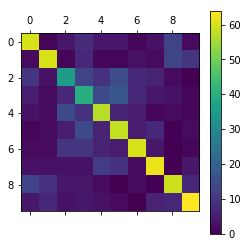

1000/1000 [==============================] - 17s 17ms/step

Models loss is 1.380638885498047
Models accuracy is 0.555


In [30]:
# Neural Network on reduced dataset

#Create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

#Define hyperparameters
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train model
model.fit(pca_x_train2, y_train, epochs=50)
print()


y_pred = model.predict_classes(pca_x_test2)
print("Confusion matrix of reduced dataset with 106 components")
cm = confusion_matrix(y_test, y_pred, [0,1,2,3,4,5,6,7,8,9])
plt.matshow(cm)
plt.colorbar()
plt.show()

#Evaluate model
val_loss, val_acc = model.evaluate(pca_x_test2, y_test)
print()
print(f"Models loss is {val_loss}")
print(f"Models accuracy is {val_acc}")